# load and roughly clean

In [29]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

csv_path = "./online_retail_II.csv"


In [2]:
"""load data"""
df = pd.read_csv(csv_path)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
"""first-step cleaning:"""

# 1. drop rows non UK and then drop country column
df = df.drop(df[df["Country"] != "United Kingdom"].index)
df = df.drop(columns=["Country"])
# 2. drop description column
df = df.drop(columns=["Description"])
# 3. drop rows with negative or 0 quantity
df = df.drop(df[df["Quantity"] <= 0].index)
# 4. drop rows with negative or 0 price
df = df.drop(df[df["Price"] <= 0].index)
# 5. drop invoice column starting with letters (cancelations)
df = df.drop(df[df["Invoice"].str.contains("^[a-zA-Z]", regex=True)].index)
# 6. only keep rows with stock code starting with 5 digits
df = df[df["StockCode"].str.contains("^[0-9]{5}", regex=True)]
# 7. drop rows with nan values
df = df.dropna()

# 8. convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
# convert CustomerID to int
df["Customer ID"] = df["Customer ID"].astype(int)

df.head()

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID
0,489434,85048,12,2009-12-01 07:45:00,6.95,13085
1,489434,79323P,12,2009-12-01 07:45:00,6.75,13085
2,489434,79323W,12,2009-12-01 07:45:00,6.75,13085
3,489434,22041,48,2009-12-01 07:45:00,2.10,13085
4,489434,21232,24,2009-12-01 07:45:00,1.25,13085


# basket analysis

In [43]:
"""second-step cleaning:"""
# we only need to know which Invoice contains which product
df_basket = df[["Invoice", "StockCode"]]

# only save the top n most frequent products 
num_top = 5

# show in each invoice which products were bought
invoice_products = df_basket.groupby('Invoice')['StockCode'].unique().to_frame(name='products')
invoice_products.head()

,products
Invoice,
489434,"[85048, 79323P, 79323W, 22041, 21232, 22064, 2..."
489435,"[22350, 22349, 22195, 22353]"
489436,"[48173C, 21755, 21754, 84879, 22119, 22142, 22..."
489437,"[22143, 22145, 22130, 21364, 21360, 21351, 213..."
489438,"[21329, 21252, 21100, 21033, 20711, 21410, 214..."


In [37]:
"""calculation of invoice support (conditional probability)"""

count_dict = {}
prob_dict = {}

# iterrate over all invoices
for _, row in tqdm(invoice_products.iterrows(), total=len(invoice_products), ascii=True):
    products = row['products']
    for product_a in products:
        count_dict[product_a] = count_dict.get(product_a, 0) + 1
        if product_a not in prob_dict:
            prob_dict[product_a] = {}
        for product_b in products:
            if product_a != product_b:
                prob_dict[product_a][product_b] = prob_dict[product_a].get(product_b, 0) + 1

# calculate conditional probability
for product_a in tqdm(prob_dict, total=len(prob_dict), ascii=True):
    for product_b in prob_dict[product_a]:
        prob_dict[product_a][product_b] /= count_dict[product_a]

# sort by probability (descending) and only keep the top5
for product in tqdm(prob_dict, total=len(prob_dict), ascii=True):
    prob_dict[product] = {k: v for k, v in sorted(prob_dict[product].items(), key=lambda item: item[1], reverse=True)}
    prob_dict[product] = {k: v for k, v in list(prob_dict[product].items())[:num_top]}


  0%|          | 0/33361 [00:00<?, ?it/s]

100%|##########| 4604/4604 [00:02<00:00, 1552.39it/s]


In [40]:
"""save the conditional probability dictionary as json file"""
with open('prob_dict.json', 'w') as fp:
    json.dump(prob_dict, fp) 

In [41]:
"""load the conditional probability dictionary from json file"""
with open('prob_dict.json', 'r') as fp:
    prob_dict = json.load(fp)

For the product 82482, the top 5 products with highest probability are:
82494L: 0.6033519553072626
85123A: 0.40782122905027934
82483: 0.27932960893854747
82486: 0.2737430167597765
82484: 0.16387337057728119


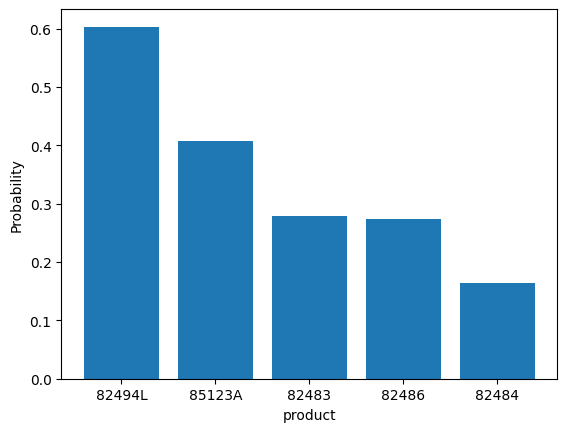

In [45]:
def show_top(prob_dict, product, num=num_top):
    # make sure the product is in the dictionary, num is positive and smaller than num_top
    assert product in prob_dict.keys()
    assert num > 0
    assert num <= num_top

    
    interesting_dict = prob_dict[product]
    key_list = list(interesting_dict.keys())[:num]
    val_list = list(interesting_dict.values())[:num]

    # display the top n products with probability
    print(f"For the product {product}, the top {num} products with highest probability are:")
    for i in range(num):
        print(f"{key_list[i]}: {val_list[i]}")

    # visualize
    plt.bar(key_list, val_list)
    plt.xlabel("product")
    plt.ylabel("Probability")
    plt.show()

show_top(prob_dict, "82482")